In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

In [2]:
# 数据集读取
data_dir = './dataset/'
train_dir = data_dir+'/train'
val_dir = data_dir+'valid'

In [3]:
# 预处理
data_transform = {
    'train':
        transforms.Compose([
        transforms.RandomResizedCrop([224,224]),#随机调整尺寸、裁剪至224x224
        transforms.RandomHorizontalFlip(p=0.5),#水平翻转，概率为0.5
        transforms.RandomVerticalFlip(p=0.5),#垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#色域调整，参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),#概率转换为灰度
        transforms.ToTensor(),#转换为灰度张量
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#归一化，参数1为均值，参数2为标准差
    ]),
    'valid':
        transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [4]:
batch_size = 32

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train','valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle= True) for x in ['train','valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 3439
     Root location: ./dataset/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=[224, 224], scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=[0.8, 1.2], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 231
     Root location: ./dataset/valid
     StandardTransform
 Transform: Compose(
                Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [6]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x19d947ff348>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x19d8c69f3c8>}

In [7]:
class_names

['1', '2', '3', '4', '5']

In [8]:
dataset_sizes

{'train': 3439, 'valid': 231}

In [5]:
#读取对应类别标签
with open ('flower_to_name.json', 'r') as f:
    flower_to_name = json.load(f)

In [6]:
flower_to_name

{'1': 'daisy',
 '2': 'tulips',
 '3': 'sunflowers',
 '4': 'dandelion',
 '5': 'roses'}

In [7]:
model_name = 'resnet'

feature_extract = True

In [8]:
# GPU训练判断
train_to_gpu = torch.cuda.is_available()

if not train_to_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available! Training on GPU ...


In [9]:
#冻结模型的层数
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad =False

In [34]:
model_ft = models.resnet50()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
#下面是一些打印操作，便于模型理解
for name,param in model_ft.named_parameters():
    print(name)
    print(param)

conv1.weight
Parameter containing:
tensor([[[[-2.6551e-03, -2.5382e-02,  1.7336e-02,  ...,  1.8282e-02,
           -1.8362e-02,  9.2397e-04],
          [ 4.5051e-02, -3.4271e-02, -2.7924e-02,  ..., -2.5314e-03,
            4.4204e-02, -1.7556e-02],
          [-1.2234e-02,  5.7574e-03, -5.5168e-03,  ...,  1.5179e-02,
            1.1682e-02, -1.4381e-02],
          ...,
          [-1.7717e-02, -2.7633e-02,  3.0798e-03,  ..., -5.4132e-02,
           -2.8040e-03, -6.4451e-02],
          [ 3.0544e-02, -3.7474e-02,  3.0901e-02,  ...,  1.4588e-02,
           -3.1278e-02, -1.2402e-02],
          [ 2.1209e-02,  2.1888e-02, -6.0564e-03,  ...,  3.0332e-02,
            5.5282e-02,  1.5890e-02]],

         [[-1.9782e-02, -1.0551e-02, -1.3186e-02,  ..., -4.9735e-02,
           -1.2714e-02,  3.7198e-03],
          [-3.7746e-02,  9.1757e-03,  2.3794e-02,  ...,  8.8485e-03,
            1.5873e-03,  6.3116e-02],
          [-1.3025e-02,  3.7514e-02, -2.8022e-02,  ..., -2.4040e-02,
           -7.0071e-03,

In [10]:
def initialize_model(model_name,num_classes, feature_extract, use_pretrained= True):

    model_ft = models.resnet50(pretrained = use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)

    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)#定义成自己的分类任务类别

    input_size = 224#输入数据大小

    return model_ft, input_size

In [11]:
model_ft, input_size = initialize_model(model_name,5, feature_extract, use_pretrained=True)

model_ft = model_ft.to(device)

#保存模型
filename = r'F:\pytorch项目\图像分类\best_model_weight.pt'

#是否训练所有层
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)


D:\anaconda\envs\openvino\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
D:\anaconda\envs\openvino\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 fc.weight
	 fc.bias


In [38]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
#优化器设置
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
#学习率衰减
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma= 0.2)#每10个epoch衰减为原来的1/10
loss_function = nn.CrossEntropyLoss()

In [13]:
def train_model(model, dataloaders, loss_function, optimizer, num_epochs, filename):
    since = time.time()#记录时间
    best_acc = 0#记录最好的一次
    model.to(device)
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    lr = [optimizer.param_groups[0]['lr']]
    best_model_weights = copy.deepcopy(model.state_dict())
    #遍历epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        #训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            #遍历数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #梯度清零
                optimizer.zero_grad()
                #训练时计算、更新梯度
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                _, preds = torch.max(outputs, 1)
                #训练阶段更新权重
                if phase == 'train':
                    loss.backward()#反向传播
                    optimizer.step()#参数更新

                #计算损失
                running_loss += loss.item() * inputs.size(0) # loss 乘以 batch
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            time_elapsed = time.time()-since#一次epoch耗时
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
            print('{} Loss :{:.4f}   Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc))

            #最好的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weight = copy.deepcopy(model.state_dict())
                state = {
                    'state_dict': model.state_dict(),
                    'best_acc': best_acc,
                    'optimizer': optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)

        print('Optimizer learning rate: {:.7f}'.format(optimizer.param_groups[0]['lr']))
        lr.append(optimizer.param_groups[0]['lr'])
        print()
        scheduler.step()#学习率衰减

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best Val Acc:{:.4f}'.format(best_acc))

    #加载训练效果最佳模型，作为后续预测基础
    model.load_state_dict(best_model_weight)

    return model, val_acc, train_acc, val_losses, train_losses, lr

In [14]:
def plot_training_history(train_losses, val_losses, train_acc, val_acc):
    plt.figure(figsize=(12, 6))  # Adjust figure size if needed

    # 获取数据列表的长度（即 epoch 数量）
    epochs = range(1, len(train_losses) + 1)

    # Plot losses (left y-axis)
    plt.plot(epochs, train_losses, label='Training Loss', linestyle='-', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--', color='blue')
    plt.ylabel('Loss', color='blue')  # Set y-axis label for loss
    plt.legend(loc='upper left')  # Place legend in the upper left corner

    # Create a second y-axis for accuracy
    ax2 = plt.twinx()  # Create a twin axis
    ax2.plot(epochs, train_acc, label='Training Accuracy', linestyle='-', color='#FFC300')
    ax2.plot(epochs, val_acc, label='Validation Accuracy', linestyle='--',color='#FFC300')
    ax2.set_ylabel('Accuracy', color='#FFC300')  # Set y-axis label for accuracy
    ax2.legend(loc='upper right')  # Place legend in the upper right corner

    plt.xlabel('Epochs')  # Set x-axis label
    plt.title('Training and Validation History')
    plt.show()


In [15]:
#开始进行第一次训练(只训练自定义的fc层)
model_ft, val_acc, train_acc, val_loss, train_loss, lr =train_model(model_ft, dataloaders, loss_function, optimizer_ft, 20 , filename)

Epoch 0/19
----------
Time elapsed 0m 43s
train Loss :1.2306   Acc:0.6947
Time elapsed 0m 44s
valid Loss :0.3566   Acc:0.9004
Optimizer learning rate: 0.0100000

Epoch 1/19
----------
Time elapsed 1m 23s
train Loss :0.7658   Acc:0.7810
Time elapsed 1m 24s
valid Loss :0.8375   Acc:0.8312
Optimizer learning rate: 0.0100000

Epoch 2/19
----------
Time elapsed 2m 3s
train Loss :0.8876   Acc:0.7761
Time elapsed 2m 5s
valid Loss :0.6182   Acc:0.8442
Optimizer learning rate: 0.0100000

Epoch 3/19
----------
Time elapsed 2m 44s
train Loss :0.9678   Acc:0.7778
Time elapsed 2m 45s
valid Loss :0.5217   Acc:0.8874
Optimizer learning rate: 0.0100000

Epoch 4/19
----------
Time elapsed 3m 25s
train Loss :0.9761   Acc:0.7825
Time elapsed 3m 26s
valid Loss :1.0784   Acc:0.8225
Optimizer learning rate: 0.0100000

Epoch 5/19
----------
Time elapsed 4m 5s
train Loss :0.9763   Acc:0.7967
Time elapsed 4m 7s
valid Loss :0.6565   Acc:0.8268
Optimizer learning rate: 0.0100000

Epoch 6/19
----------
Time elaps

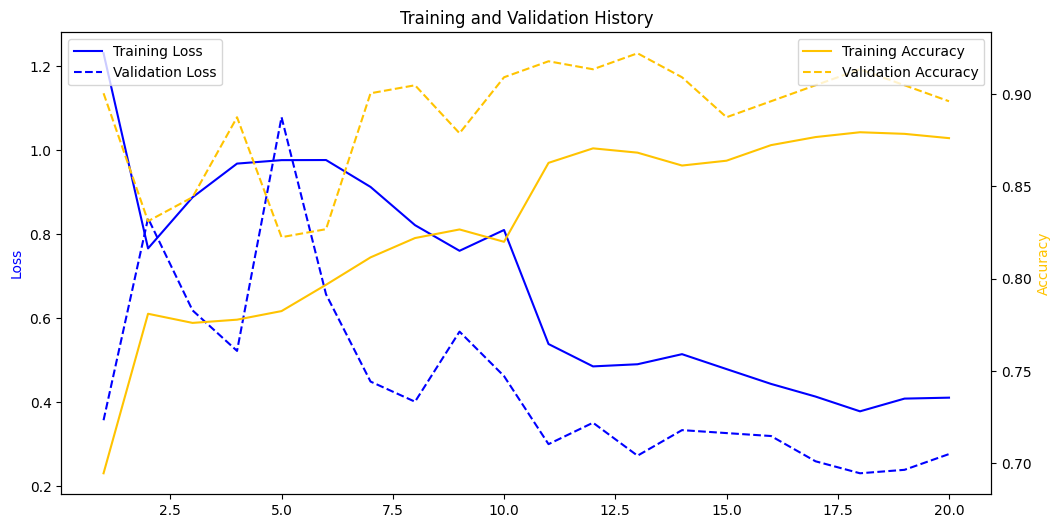

In [16]:
#绘制训练曲线
plot_training_history(train_loss,val_loss, train_acc, val_acc)

In [36]:
#再次训练所有层
for param in model_ft.parameters():
    param.requires_grad = True

#二次设置超参数，进行微调
optimizer_ft = optim.Adam(params_to_update, lr=1e-3)
#学习率衰减
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma= 0.2)#每10个epoch衰减为原来的1/10
loss_function = nn.CrossEntropyLoss()

In [37]:
#加载训练好的权重参数
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [38]:
#进行第二次训练(只训练自定义的fc层)
model_ft, val_acc, train_acc, val_loss, train_loss, lr =train_model(model_ft, dataloaders, loss_function, optimizer_ft, 20 , filename)

Epoch 0/19
----------
Time elapsed 1m 3s
train Loss :0.4084   Acc:0.8697
Time elapsed 1m 12s
valid Loss :0.2450   Acc:0.9177
Optimizer learning rate: 0.0010000

Epoch 1/19
----------
Time elapsed 7m 37s
train Loss :0.3839   Acc:0.8776
Time elapsed 7m 42s
valid Loss :0.3061   Acc:0.9134
Optimizer learning rate: 0.0010000

Epoch 2/19
----------
Time elapsed 12m 52s
train Loss :0.3738   Acc:0.8805
Time elapsed 12m 56s
valid Loss :0.2512   Acc:0.9177
Optimizer learning rate: 0.0010000

Epoch 3/19
----------
Time elapsed 17m 0s
train Loss :0.3810   Acc:0.8723
Time elapsed 17m 4s
valid Loss :0.2423   Acc:0.9048
Optimizer learning rate: 0.0010000

Epoch 4/19
----------
Time elapsed 22m 28s
train Loss :0.3887   Acc:0.8773
Time elapsed 22m 32s
valid Loss :0.2532   Acc:0.9048
Optimizer learning rate: 0.0010000

Epoch 5/19
----------
Time elapsed 26m 43s
train Loss :0.3289   Acc:0.8843
Time elapsed 26m 48s
valid Loss :0.2241   Acc:0.9091
Optimizer learning rate: 0.0002000

Epoch 6/19
----------
T

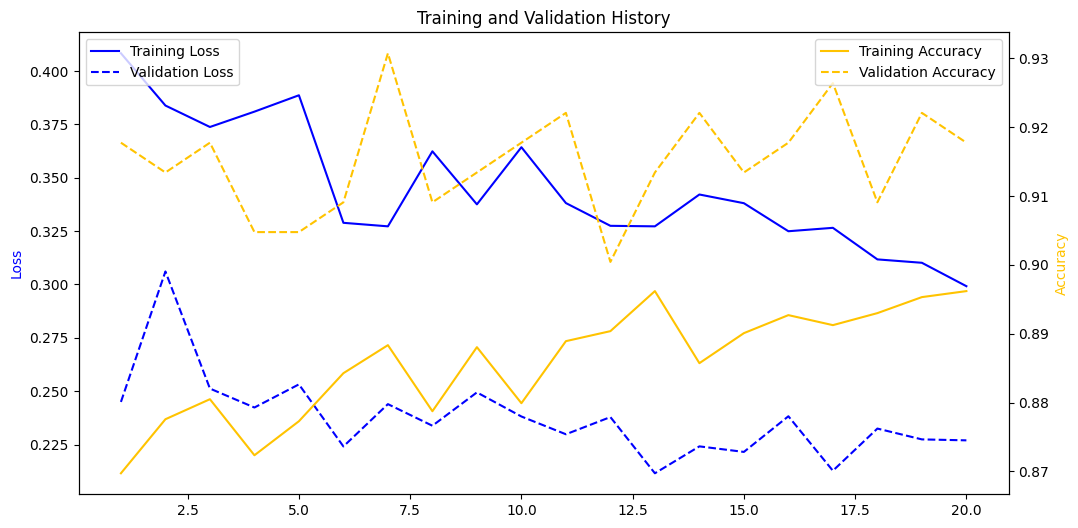

In [42]:
#再次绘制曲线
plot_training_history(train_loss,val_loss, train_acc, val_acc)

In [51]:
# create model
model_name = 'resnet'
model, input_size = initialize_model(model_name, 5, feature_extract=True, use_pretrained=True)
model = model.to(device)

# load model weights
filename = r'F:\pytorch项目\图像分类\best_model_weight.pt'
checkpoint = torch.load(filename, map_location=device)
best_acc = checkpoint['best_acc']
model.load_state_dict(checkpoint['state_dict'])
assert os.path.exists(filename), "file: '{}' dose not exist.".format(filename)

In [76]:
#得到1个batch的测试数据
dataiter = iter(dataloaders['valid'])
images, labels = dataiter.next()

model.eval()

if train_to_gpu:
    output = model(images.cuda())
else:
    output = model(images)

In [53]:
output.shape

torch.Size([32, 5])

In [54]:
output

tensor([[-2.2609e+00,  3.9383e+00,  4.4734e+00,  2.4193e-01,  1.4596e+01],
        [ 4.5817e+00,  1.1578e+01,  1.6526e-01,  1.0525e+00,  3.8460e+00],
        [ 1.6019e+00,  1.2508e+01,  3.8751e+00, -3.5922e+00,  1.2409e+01],
        [-8.9168e-01,  5.8290e+00,  5.1231e+00,  5.2367e+00,  3.8865e+00],
        [ 6.6614e+00,  3.9730e-01,  3.2344e+00,  1.2953e+01,  2.7366e+00],
        [ 1.9502e+00,  5.9782e+00, -1.4173e+00,  1.1878e+01, -1.2032e+00],
        [-3.2553e+00,  9.3390e+00,  1.9963e+00, -2.1633e+00,  1.5918e+01],
        [ 6.2959e+00,  3.2045e+00,  1.1765e+01,  2.8149e+00, -6.5383e-01],
        [ 4.7831e+00,  1.1883e+00,  1.0778e+01,  3.6613e+00, -1.6598e+00],
        [-1.7465e+00,  6.0441e+00,  1.1875e+00, -2.5104e+00,  1.6039e+01],
        [ 8.1530e+00,  9.7957e+00, -2.1019e-02, -5.5336e-01,  8.4560e+00],
        [ 3.5434e+00, -6.2545e-01,  1.4860e+01,  7.4382e+00, -4.5736e+00],
        [ 2.2659e+01,  3.0683e+00,  1.4990e+00,  4.5708e+00, -1.3966e+01],
        [-5.3902e+00,  1.

In [77]:
_, preds_tensor = torch.max(output,1)

preds = np.squeeze(preds_tensor.numpy()) if not train_to_gpu else np.squeeze(preds_tensor.cpu().numpy())

In [73]:
#数据转换
def im_convert(tensor):

    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)#将数据从C×H×W,变成H×W×C
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))#数据从标准化还原成原始数据格式
    image = image.clip(0, 1)

    return image

In [78]:
# 计算准确率
correct = (preds == labels.numpy()).sum()
total = len(preds)
accuracy = correct / total

print(f"Batch Accuracy: {accuracy:.4f}")


Batch Accuracy: 0.9688


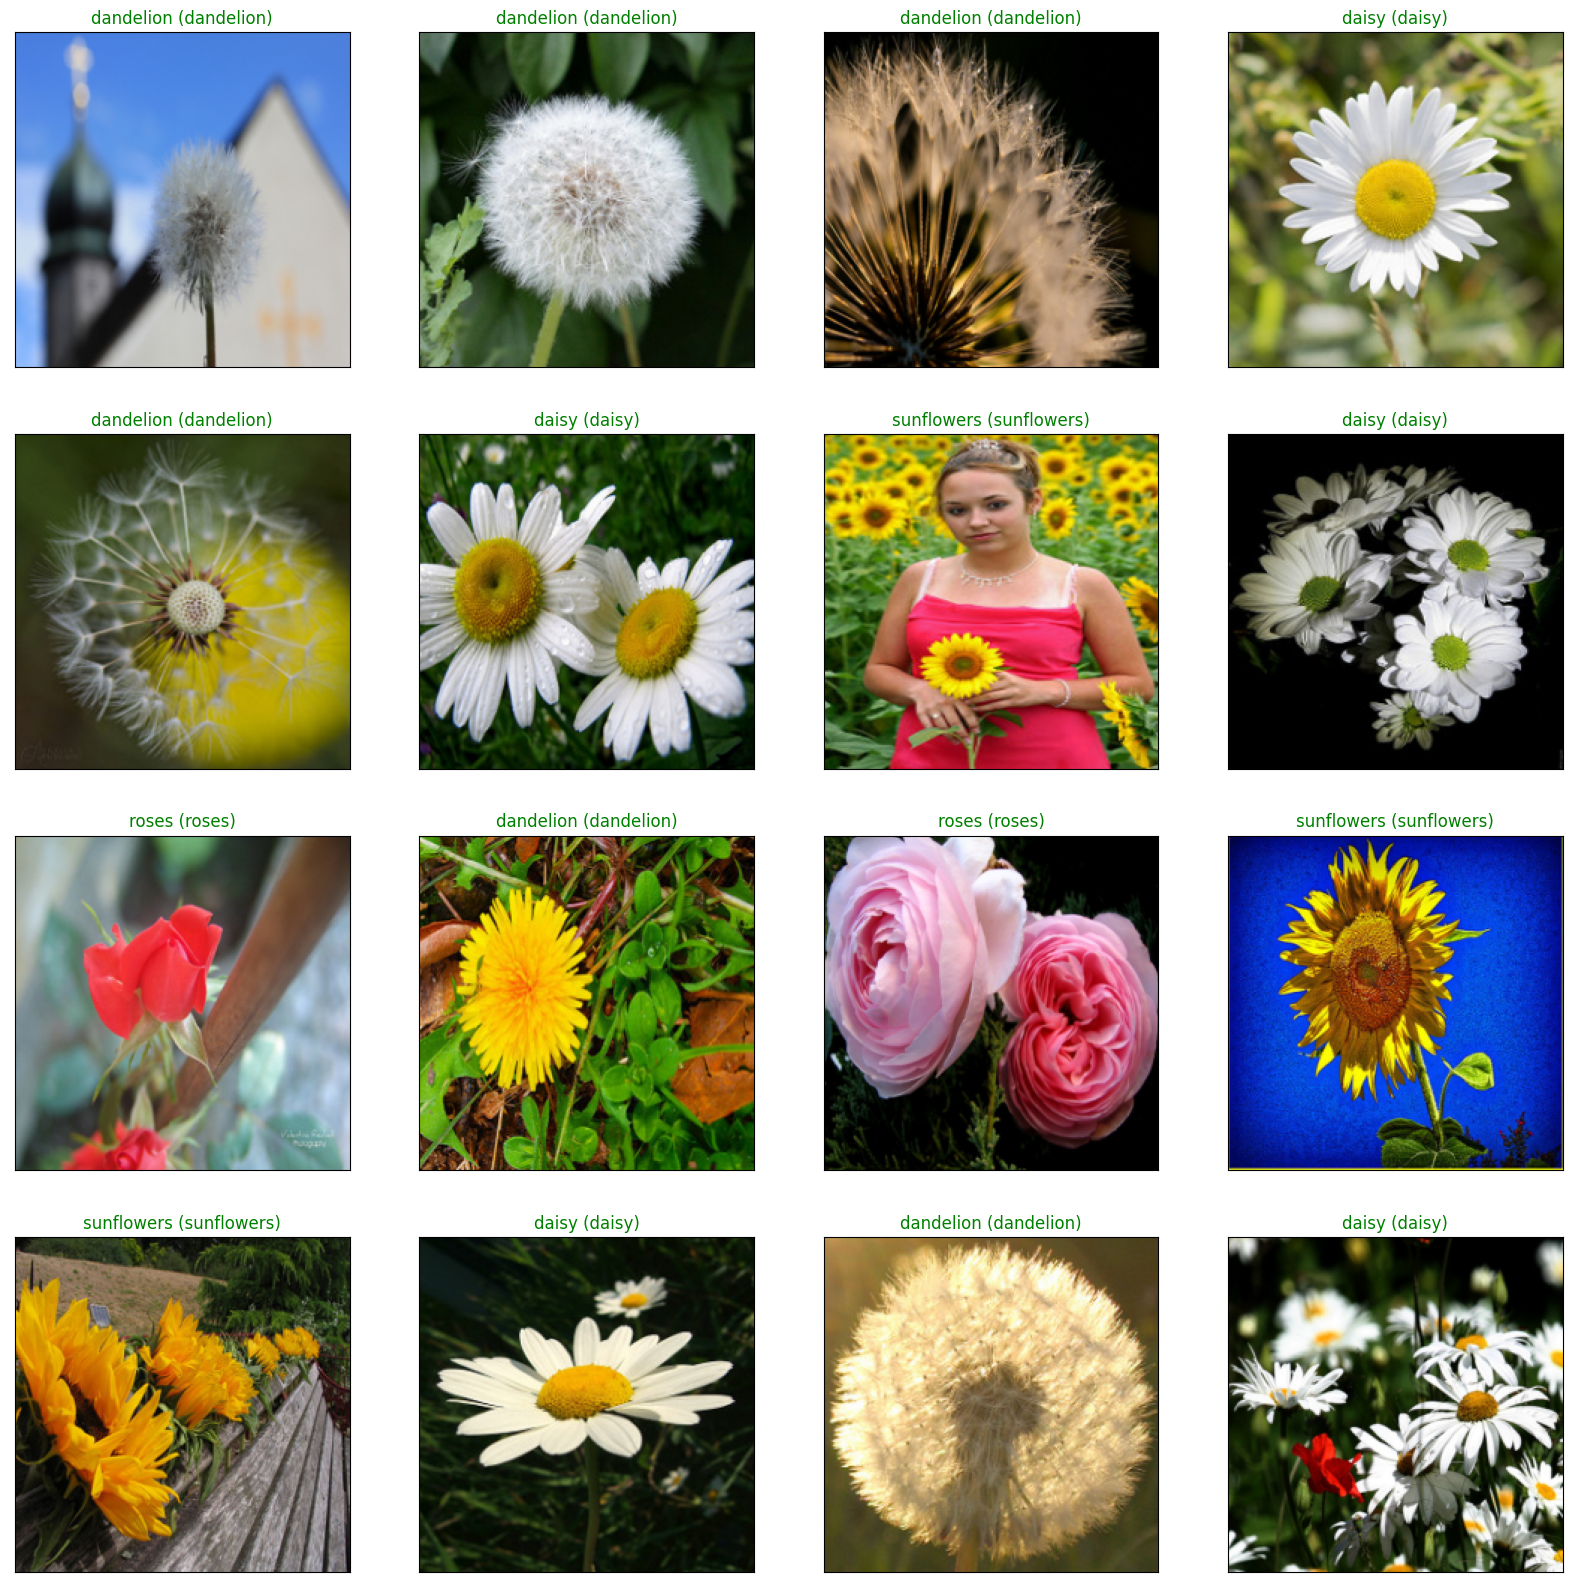

In [79]:
fig = plt.figure(figsize=(20, 20))
column = 4
rows = 4

for idx in range(column * rows):
    ax = fig.add_subplot(rows, column, idx + 1)  # 不再使用 xtricks 和 ytricks
    plt.imshow(im_convert(images[idx]))
    # 注意这里将 preds[idx] 和 labels[idx].item() 加 1
    ax.set_title("{} ({})".format(flower_to_name[str(preds[idx] + 1)], flower_to_name[str(labels[idx].item() + 1)]),
                color=("green" if flower_to_name[str(preds[idx] + 1)] == flower_to_name[str(labels[idx].item() + 1)] else "red"))
    # 隐藏刻度线和标签
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()